In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from period_detection import find_period

In [8]:
find_period(path="./dataset/multivariate/oisst_lat_14.0_lon_112.0.csv")

KeyError: 'value'

In [4]:
df = pd.read_csv("./dataset/multivariate/oisst_lat_14.0_lon_112.0.csv")
df

,date,mslp,slhf,sshf,ssr,str,z500,z850,w10,wz500,wz850,sst
0,1981-09-01,100747.010,-469802.38,-13879.336,965253.20,-164621.73,57458.453,14612.531,8.748818,2.801020,9.657326,28.140000
1,1981-09-02,100798.820,-432472.60,-22769.412,891725.60,-163932.03,57449.160,14657.481,7.542623,3.114795,5.282436,28.267500
2,1981-09-03,100762.600,-482590.75,-27607.145,936436.06,-171049.70,57356.496,14621.309,7.894445,0.994348,6.034229,27.910000
3,1981-09-04,100770.660,-458046.20,-27206.750,988204.44,-192117.78,57374.290,14614.673,7.199119,2.566582,4.768841,27.717497
4,1981-09-05,100890.590,-459249.34,-31879.484,971465.00,-187425.23,57473.890,14705.230,6.607411,3.268076,5.492439,28.705000
...,...,...,...,...,...,...,...,...,...,...,...,...
15092,2022-12-27,101458.445,-821170.60,-84925.490,601846.30,-193655.72,57593.535,14954.710,9.970309,2.664845,7.372163,26.892498
15093,2022-12-28,101453.266,-613362.40,-43964.723,549188.10,-168267.80,57547.290,14989.224,8.517898,2.600887,7.540432,26.822498
15094,2022-12-29,101532.086,-716134.44,-93106.234,227806.08,-118894.41,57546.900,15038.321,11.482700,8.220467,12.698573,26.677498
15095,2022-12-30,101582.984,-1115293.40,-146360.000,427357.25,-150902.94,57610.047,15037.827,14.508407,4.341895,15.459295,26.627500


In [53]:
# only choose the date and sst columns

# df_new = df[['date', 'sst']]
# txt = './periods.txt'
# with open(txt, 'a') as f:
    # lines = f.readlines()
    # for line in lines:
    #     print(line)

Scaler = StandardScaler()
array = Scaler.fit_transform(df.iloc[-365:, 1:])
# array.shape

xf = torch.fft.rfft(torch.tensor(array), dim=0)
amps = torch.abs(xf).mean(dim=1)
periods = 365 / amps.sort(descending=True).indices[:15]
print(periods)

# periods_list = []

# columns = df.columns[1:]
# for i in range(len(columns)):
#     # print(columns[i])
#     xf = torch.fft.rfft(torch.tensor(df[columns[i]].to_numpy())[-365:])
#     amps = torch.abs(xf)
#     periods = 365 / amps.sort(descending=True).indices[:15]
#     periods_list.append(periods[1:])
#     # print(periods[1:])
#         # with open(txt, 'a') as f:
#     #     f.write(columns[i] + '\n')
#     #     for period in periods:
#     #         f.write(str(period.item()) + '\n')
#     #     f.write('\n')
    
#     # f.close()

# periods_list = np.array(periods_list)
# print(periods_list)
# find the numbers of same periods of last row
# base_line = periods_list[-1]
# numbers = []
# search_array = periods_list[:-1]
# for i in range(len(base_line)):
#     count = 0
#     for j in range(len(search_array)):
#         if base_line[i] in search_array[j]:
#             count += 1
#     numbers.append(count)
# print(numbers)
# common_periods = np.array([])
# for i in range(len(periods_list)):
#     if i == 0:
#         common_periods = periods_list[i]
#     else:
#         common_periods = np.intersect1d(common_periods, periods_list[i])
# print(common_periods)

tensor([365.0000,  40.5556,  60.8333, 182.5000,  73.0000,  17.3810,  18.2500,
         91.2500,  45.6250,  36.5000,  13.0357,  52.1429,  16.5909,  20.2778,
          9.6053])


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [154]:

class AdaptiveFastFourierTransform(nn.Module):
    def __init__(self, num_features, d_model):
        super().__init__()
        self.start_fc = nn.Linear(num_features, d_model) # 11->512
        self.gate_threshold = 0.75
        self.scale = 0.1
        len_high_freq = int(math.sqrt(365//2))
        len_low_freq = 365//2 - len_high_freq
        self.w1 = nn.Parameter(self.scale * torch.randn(2, len_high_freq, len_high_freq*4))
        self.b1 = nn.Parameter(self.scale * torch.randn(2, len_high_freq*4))
        self.w2 = nn.Parameter(self.scale * torch.randn(2, len_high_freq*4, 365//2))
        self.b2 = nn.Parameter(self.scale * torch.randn(2, 365//2))
        self.w3 = nn.Parameter(self.scale * torch.randn(2, len_low_freq, len_low_freq*4))
        self.b3 = nn.Parameter(self.scale * torch.randn(2, len_low_freq*4))
        self.w4 = nn.Parameter(self.scale * torch.randn(2, len_low_freq*4, 365//2))
        self.b4 = nn.Parameter(self.scale * torch.randn(2, 365//2))


    def sru(self, xf):
        # xf [B, L//2+1, D]
        B, L, D = xf.shape
        xf_dc = xf[:, 0, :] # B, D
        xf_ac = xf[:, 1:, :] # B, L//2, D
        amplitudes = torch.abs(xf_ac).mean(-1) # B, L//2+1
        weights = amplitudes / amplitudes.sum(dim=-1, keepdim=True) # B, L//2+1
        re_weights = F.sigmoid(weights) # B, L//2+1
        info_mask = re_weights >= self.gate_threshold   # 计算信息门控掩码
        no_info_mask = re_weights <= self.gate_threshold    # 计算非信息门掩码
        xf_real_1 = xf_ac.real * info_mask.unsqueeze(-1)
        xf_imag_1 = xf_ac.imag * info_mask.unsqueeze(-1)
        xf_real_2 = xf_ac.real * no_info_mask.unsqueeze(-1)
        xf_imag_2 = xf_ac.imag * no_info_mask.unsqueeze(-1)
        xf_real = self.reconstruct(xf_real_1, xf_real_2)
        xf_imag = self.reconstruct(xf_imag_1, xf_imag_2)
        xf_ac = torch.complex(xf_real, xf_imag)
        xf = torch.cat([xf_dc.unsqueeze(1), xf_ac], dim=1)
        return xf

        # x_1 = info_mask * xf     # 使用信息门控掩码
        # x_2 = no_info_mask * xf # 使用非信息们控掩码
        # x = self.reconstruct(x_1, x_2)  # 特征重构

    def reconstruct(self, x_1, x_2):
        # 特征拆分为两部分
        x_11, x_12 = torch.split(x_1, [x_1.size(1) // 2, x_1.size(1) - x_1.size(1) // 2], dim=1)
        x_21, x_22 = torch.split(x_2, [x_2.size(1) // 2, x_2.size(1) - x_2.size(1) // 2], dim=1)
        return torch.cat([x_11 + x_22, x_12 + x_21], dim=1)    # 重构特征并连接
    
    def cru(self, xf):
        # xf [B, L//2+1, D]
        B, L, D = xf.shape
        len_high_freq = int(math.sqrt(L-1)) # 高频部分长度
        xf_dc = xf[:, 0, :] # B, D
        xf_ac = xf[:, 1:, :] # B, L//2, D
        xf_high = xf_ac[:, :len_high_freq, :] # B, len_high_freq, D
        xf_low = xf_ac[:, len_high_freq:, :] # B, L//2-len_high_freq, D
        xf_high = xf_high.transpose(1, 2) # B, D, len_high_freq
        xf_low = xf_low.transpose(1, 2) # B, D, L//2-len_high_freq

        o1_real = F.relu(
            torch.einsum('...i,io->...o', xf_high.real, self.w1[0]) - \
            torch.einsum('...i,io->...o', xf_high.imag, self.w1[1]) + \
            self.b1[0]
        )

        o1_imag = F.relu(
            torch.einsum('...i,io->...o', xf_high.imag, self.w1[0]) + \
            torch.einsum('...i,io->...o', xf_high.real, self.w1[1]) + \
            self.b1[1]
        )

        o2_real = (
            torch.einsum('...i,io->...o', o1_real, self.w2[0]) - \
            torch.einsum('...i,io->...o', o1_imag, self.w2[1]) + \
            self.b2[0]
        )

        o2_imag = (
            torch.einsum('...i,io->...o', o1_imag, self.w2[0]) + \
            torch.einsum('...i,io->...o', o1_real, self.w2[1]) + \
            self.b2[1]
        )
        
        o3_real = F.relu(
            torch.einsum('...i,io->...o', xf_low.real, self.w3[0]) - \
            torch.einsum('...i,io->...o', xf_low.imag, self.w3[1]) + \
            self.b3[0]
        )

        o3_imag = F.relu(
            torch.einsum('...i,io->...o', xf_low.imag, self.w3[0]) + \
            torch.einsum('...i,io->...o', xf_low.real, self.w3[1]) + \
            self.b3[1]
        )

        o4_real = (
            torch.einsum('...i,io->...o', o3_real, self.w4[0]) - \
            torch.einsum('...i,io->...o', o3_imag, self.w4[1]) + \
            self.b4[0]
        )

        o4_imag = (
            torch.einsum('...i,io->...o', o3_imag, self.w4[0]) + \
            torch.einsum('...i,io->...o', o3_real, self.w4[1]) + \
            self.b4[1]
        )

        weights_high = F.softmax(torch.cat([o2_real, o4_real], dim=-1).mean(-2), dim=-1)
        weights_low = F.softmax(torch.cat([o2_imag, o4_imag], dim=-1).mean(-2), dim=-1)

        weights_high_1 = weights_high[:, :o2_real.size(2)]
        weights_high_2 = weights_high[:, o2_real.size(2):]
        weights_low_1 = weights_low[:, :o2_imag.size(2)]
        weights_low_2 = weights_low[:, o2_imag.size(2):]
        print(o2_real.shape, weights_high_1.shape)
        o2_real = o2_real * weights_high_1.unsqueeze(-2)
        o2_imag = o2_imag * weights_low_1.unsqueeze(-2)
        o4_real = o4_real * weights_high_2.unsqueeze(-2)
        o4_imag = o4_imag * weights_low_2.unsqueeze(-2)

        xf_1 = o2_real + o4_real
        xf_2 = o2_imag + o4_imag

        xf_1 = xf_1.transpose(1, 2)
        xf_2 = xf_2.transpose(1, 2)

        xf_ac = torch.complex(xf_1, xf_2)
        
        xf = torch.cat([xf_dc.unsqueeze(1), xf_ac], dim=1)
        return xf

    def forward(self, x):
        n_vars = x.size(-1)
        x = self.start_fc(x) # B, L, D
        xf = torch.fft.rfft(x, dim=1, norm='ortho') # B, L//2+1, D
        amplitude = torch.abs(xf).mean(-1) # B, L//2+1, D
        plt.plot(amplitude[0, :300].detach().numpy())
        # xf = self.sru(xf)
        # amplitude = torch.abs(xf).mean(-1) # B, L//2+1, D
        # plt.plot(amplitude[0].detach().numpy())
        # xf = self.cru(xf)
        # amplitude = torch.abs(xf).mean(-1) # B, L//2+1, D
        # plt.plot(amplitude[0].detach().numpy())

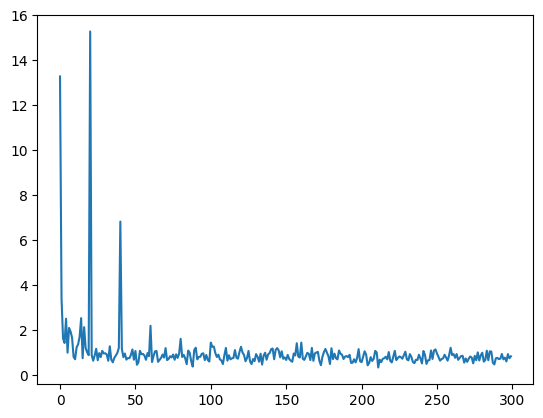

In [155]:
df = pd.read_csv("./dataset/multivariate/oisst_lat_14.0_lon_112.0.csv")
data = df.iloc[-7300:, 1:].to_numpy()
data = Scaler.fit_transform(data)
data = torch.tensor(data).float()
data = data.unsqueeze(0)
model = AdaptiveFastFourierTransform(11, 512)
model(data)

In [3]:
import torch
import numpy as np
import pandas as pd

In [4]:
x = torch.randn(8, 365)\



patch_sizes = (1 / torch.fft.rfftfreq(365)[1:]).floor().int().unique().detach().cpu().numpy()[::-1]
print(patch_sizes)
xf = torch.fft.rfft(x, dim=-1, norm='ortho') # [B, L//2+1]

amplitudes = torch.abs(xf) # [B, L//2+1]

freqs = torch.fft.rfftfreq(365) # [L//2+1]
print(freqs)
weights = []

# for patch_size in patch_sizes:

[365 182 121  91  73  60  52  45  40  36  33  30  28  26  24  22  21  20
  19  18  17  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2]
tensor([0.0000, 0.0027, 0.0055, 0.0082, 0.0110, 0.0137, 0.0164, 0.0192, 0.0219,
        0.0247, 0.0274, 0.0301, 0.0329, 0.0356, 0.0384, 0.0411, 0.0438, 0.0466,
        0.0493, 0.0521, 0.0548, 0.0575, 0.0603, 0.0630, 0.0658, 0.0685, 0.0712,
        0.0740, 0.0767, 0.0795, 0.0822, 0.0849, 0.0877, 0.0904, 0.0932, 0.0959,
        0.0986, 0.1014, 0.1041, 0.1068, 0.1096, 0.1123, 0.1151, 0.1178, 0.1205,
        0.1233, 0.1260, 0.1288, 0.1315, 0.1342, 0.1370, 0.1397, 0.1425, 0.1452,
        0.1479, 0.1507, 0.1534, 0.1562, 0.1589, 0.1616, 0.1644, 0.1671, 0.1699,
        0.1726, 0.1753, 0.1781, 0.1808, 0.1836, 0.1863, 0.1890, 0.1918, 0.1945,
        0.1973, 0.2000, 0.2027, 0.2055, 0.2082, 0.2110, 0.2137, 0.2164, 0.2192,
        0.2219, 0.2247, 0.2274, 0.2301, 0.2329, 0.2356, 0.2384, 0.2411, 0.2438,
        0.2466, 0.2493, 0.2521, 0.2548, 0.2575, 0.260